# CLaP Example Visualization
In this notebook, we visualize an example of CLaP.

In [1]:
# fot type settings for paper plots
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
import sys
sys.path.append("../../")

import numpy as np
import pandas as pd

from src.utils import load_tssb_datasets, load_has_datasets, load_datasets
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

from src.visualization import plot_state_detection
from src.clap import CLaP

sns.set_theme()
sns.set_color_codes()

import os

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Let's first load the data and select a TS.

In [3]:
df_data = load_has_datasets()
df_data

,dataset,window_size,change_points,labels,time_series
0,indoor_subject1_routine1 (id125),50,"[1461, 2952, 4473, 5022, 6460]","[1, 0, 1, 2, 0, 3]","[[0.5025029458177382, 0.78151899859646, 0.4075..."
1,indoor_subject1_routine1 (id140),50,"[772, 2056, 3521, 4835, 5283, 6893]","[2, 1, 3, 1, 2, 0, 3]","[[0.41870591057777035, 0.8157450984128195, 0.3..."
2,indoor_subject1_routine1 (id93),50,"[1211, 2043, 2836, 3529, 4036]","[2, 4, 0, 1, 3, 4]","[[0.6809143354242022, 0.8390696507060063, 0.34..."
3,indoor_subject1_routine1 (id52),50,"[739, 1433, 2044, 2875, 3589]","[0, 1, 2, 3, 1, 0]","[[0.5215244935774459, 0.7310931419213416, 0.50..."
4,indoor_subject1_routine1 (id221),50,"[1506, 3033, 4477, 5348, 6805]","[2, 0, 2, 3, 0, 1]","[[0.48401058282315657, 0.6748131355527517, 0.5..."
...,...,...,...,...,...
245,outdoor_subject7_routine3 (id26),50,[],[0],"[[0.7491045845272207, 0.5873851669280753, 0.53..."
246,outdoor_subject7_routine3 (id48),50,[],[0],"[[0.07761887299841085, 0.9513191404126248, 0.3..."
247,outdoor_subject7_routine3 (id78),50,"[529, 1778]","[1, 0, 1]","[[0.48061181058716396, 0.5648863723314714, 1.0..."
248,outdoor_subject7_routine3 (id163),50,[],[0],"[[0.17304133251079593, 0.8704303563165199, 0.2..."


In [4]:
idx = 112
data_row = df_data.iloc[idx]

Now, we plot the TS and three annotated CLaPs.

In [5]:
np.random.seed(2357)

time_series = data_row.time_series[:,:3]

# sub-select TS
time_series = time_series[700:] # [:data_row.change_points[2]]
change_points = data_row.change_points - 700 # [:2]
labels = data_row.labels # [:2]

# create CLaPs
clap = CLaP()
clap.window_size = 50
scored_claps = []

# create noise probabilities
noise = [1, .5, 0]

for idx in range(3):
    X, y = clap._create_dataset(time_series, change_points, labels)
    
    # add noise to labels
    ind = np.random.choice(y.shape[0], int(noise[idx] * y.shape[0]), replace=False)
    y[ind] = np.random.choice(np.unique(labels), ind.shape[0], replace=True)
    
    y_true, y_pred = clap._cross_val_classifier(X, y)
    scored_claps.append((f1_score(y_true, y_pred, average="macro"), y_true))

<Figure size 640x480 with 0 Axes>

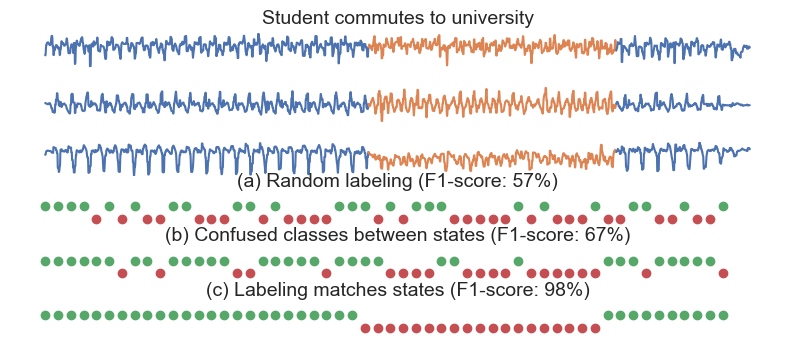

In [6]:
plt.clf()

font_size = 14

fig, axes = plt.subplots(
    time_series.shape[1] + 3,
    sharex=True,
    gridspec_kw={'hspace': .5},
    figsize=(10, 4)
)

label_colours = {}
label_colours2 = {}
idx = 0

# create colours (for TS)
for label in labels:
    if label not in label_colours:
        label_colours[label] = f"C{idx}"
        idx += 1
        
# create colours (for CLaP)
for label in labels:
    if label not in label_colours2:
        label_colours2[label] = f"C{idx}"
        idx += 1

# plot TS
for dim, ax in enumerate(axes[:time_series.shape[1]]):
    ts = time_series[:,dim]
    segments = [0] + change_points.tolist() + [ts.shape[0]]
    
    for idx in np.arange(0, len(segments) - 1):
        ax.plot(
            np.arange(segments[idx], segments[idx + 1]),
            ts[segments[idx]:segments[idx + 1]],
            c=label_colours[data_row.labels[idx]]
        )
        
clap_titles = [
    "(a) Random labeling",
    "(b) Confused classes between states",
    "(c) Labeling matches states"
]
        
# plot CLaPs
for idx, ax in enumerate(axes[time_series.shape[1]:]):
    score, y_true = scored_claps[idx]
    
    for kdx, label in enumerate(y_true):
        if kdx % 2 == 0:
            ax.scatter(kdx * clap.window_size // 2, label, c=label_colours2[label])
        
    ax.set_yticks(np.arange(-1, 2, .1))
    ax.set_title(clap_titles[idx] + f" (F1-score: {int(score * 100)}%)", fontsize=font_size)

# adjust axes style
for dim, ax in enumerate(axes):
    ax.set_facecolor((1., 1., 1.))
    
    ax.tick_params(
        axis='both',          
        which='both',      
        labelbottom=False,
        labelleft=False
    )
    
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(font_size)

    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(font_size)

axes[0].set_title("Student commutes to university", fontsize=font_size)
plt.savefig("../../figures/clap_example.pdf", bbox_inches="tight")